### Load data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import seaborn as sns
sns.set(color_codes=True)

In [2]:
df = pd.read_csv('Collection_Risk.csv')
# change column nams to lower case
df.columns = df.columns.str.lower()

In [3]:
%qtconsole

### Exploration data analysis

In [4]:
train = df[df.ind <= 9]
test = df[df.ind == 10]
train.head()

,student_id,future,aging,program,degree,college,bb_activity_latest,bb_gip_etc_ratio_std,cum_gpa,cum_credits,...,nation_desc,ind,current_balance,module_cp,day_since_end,in_module,day_since_begin,in_future,day_to_begin,in_dissertation
0,J00044040,1111.11,90,MBA,MBA,MG,2,123.791558,2.0,60,...,QATAR,9,0.11,6,86,1,71,1,27,0
2,J00044056,1111.11,0,MS_ISM,MS,MG,0,0.000000,0.6,0,...,NIGERIA,7,0.00,1,717,0,365,0,365,0
3,J00044056,1111.11,0,MS_ISM,MS,MG,0,0.000000,0.6,0,...,NIGERIA,8,0.00,1,748,0,365,0,365,0
4,J00044067,1111.11,0,MBA,MBA,MG,58,63.046788,2.2,80,...,SOUTH AFRICA,9,0.00,6,86,0,365,1,27,0
5,J00044071,0.00,30,MS_PRJ,MS,MG,43,0.000000,2.4,100,...,NIGERIA,7,1111.11,8,18,1,17,0,365,1


Utility functions to show the properties of each feature w.r.t the target

In [5]:
def single_cat(dSet, feature, target = 'risk'):
    """ exploring single categorical variable"""
    print "number of missing values =", dSet[feature].isnull().sum()
    
    #cross tabulation of feature v.s. target
    ctab = pd.crosstab(dSet[target], dSet[feature])
    rate = (ctab.iloc[1] / ctab.sum(axis = 0)).to_frame().T
    rate.index = range(2,3)
    ctab = pd.concat([ctab, rate])
    print ctab


In [6]:
def single_num(dSet, feature, target = 'risk'):
    """ exploring single numerical variable"""
    print "number of missing values =", dSet[feature].isnull().sum()
    print "summary of the whole set"
    print dSet[feature].describe()
    print "summary of subset with target = 0"
    print dSet[dSet[target] == 0][feature].describe()
    print "summary of subset with target = 1"
    print dSet[dSet[target] == 1][feature].describe()
    sns.plt.title('double density plot')
    sns.kdeplot(train[train[target]==0][feature], label = target + ' = 0')
    sns.kdeplot(train[train['risk']==1]['bb_activity_latest'], label = target + ' = 1')

#### aging

number of missing values = 0
summary of the whole set
count    7813.000000
mean       74.817612
std       103.293105
min         0.000000
25%         0.000000
50%        30.000000
75%        90.000000
max       360.000000
Name: aging, dtype: float64
summary of subset with target = 0
count    3489.000000
mean       35.821152
std        57.288883
min         0.000000
25%         0.000000
50%        30.000000
75%        60.000000
max       360.000000
Name: aging, dtype: float64
summary of subset with target = 1
count    4324.000000
mean      106.283534
std       120.061647
min         0.000000
25%        30.000000
50%        60.000000
75%       150.000000
max       360.000000
Name: aging, dtype: float64


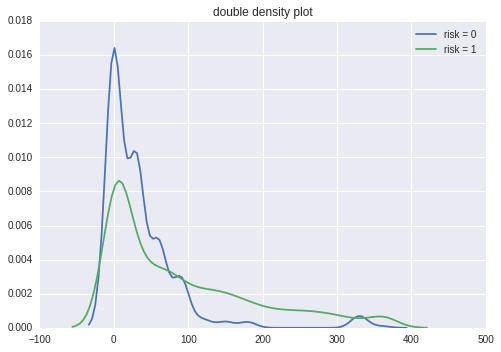

In [7]:
single_num(train, 'aging')

No missing value.
clearly longer aging --> higher risk

#### college

In [8]:
single_cat(train, 'college')

number of missing values = 0
college          ED           MG         PA           PH          PY
0        530.000000  1941.000000  59.000000   788.000000  171.000000
1        480.000000  2577.000000  94.000000  1042.000000  131.000000
2          0.475248     0.570385   0.614379     0.569399    0.433775


No missing values. 
There is some observable difference across colleges


 #### cp_prior3mon_pay_total

number of missing values = 0
summary of the whole set
count    7813.000000
mean      307.369557
std       480.123325
min      -814.810000
25%         0.000000
50%         0.000000
75%       533.330000
max      6716.800000
Name: cp_prior3mon_pay_total, dtype: float64
summary of subset with target = 0
count    3489.000000
mean      536.322221
std       532.416251
min         0.000000
25%         0.000000
50%       410.040000
75%      1111.110000
max      2666.660000
Name: cp_prior3mon_pay_total, dtype: float64
summary of subset with target = 1
count    4324.000000
mean      122.629537
std       333.776852
min      -814.810000
25%         0.000000
50%         0.000000
75%         0.000000
max      6716.800000
Name: cp_prior3mon_pay_total, dtype: float64


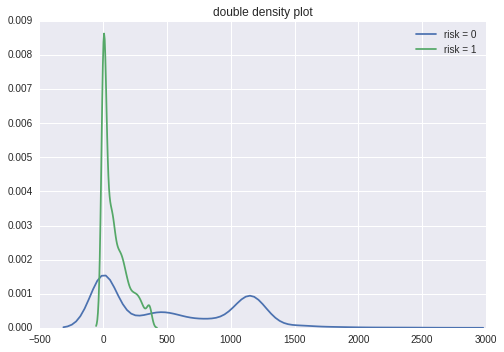

In [9]:
single_num(train, 'cp_prior3mon_pay_total')

There is an outlier -814.81, could be data error, another outlier 6717. Remove them before moving on.

In [10]:
train = train[(train.cp_prior3mon_pay_total >= 0) &  (train.cp_prior3mon_pay_total < 2700)]

### Explore one-variable model

In [30]:
def mkPredC(outCol, varCol, appCol):
    """outCol: the target column of the training data
       varCol: the variable column of the training data
       appCol: the variable column of the test/validate data
    this fuctions build a cross table of target v.s. a single categorical variable 
    using the training data and applied it to the appCol
       """
    pos = 1
    pPos = float(sum(outCol == pos)) /outCol.shape[0]
    print pPos
    vTab = pd.crosstab(outCol, varCol)
    print vTab
    pPosWv = (vTab.iloc[1] + 1.0e-3 * pPos) / (vTab.sum(axis = 0) + 1.0e-3)
    pred = pPosWv[appCol]
    return pred

In [25]:
def cut(v, cuts):
    for i in range(cuts.shape[0] - 1):
        if v >= cuts[i] and v <= cuts[i+1]:
            return i
    return i

def mkPredN(outCol, varCol, appCol):
    pos = 1
    cuts = np.unique(np.percentile(varCol, range(0,110,10)))
    varC = pd.Series(map(lambda x: cut(x, cuts), varCol))
    appC = pd.Series(map(lambda x: cut(x, cuts), appCol))
    #return mkPredC(outCol,varC,appC)
    return cuts, varC, appC